In [0]:
monisha = True
loc = '/content/drive/My Drive/6.871 ML with HC/Project/' if monisha else '/content/drive/My Drive/Project/'

In [0]:
import pickle
from itertools import islice

In [9]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Install 

In [10]:
import torch
!pip install transformers
from transformers import *

In [0]:
df = pd.read_csv(loc + 'data/AnonymizedClinicalAbbreviationsAndAcronymsDataSet.txt', sep = '|', encoding='latin1', header = None, 
                 names = ['Long_Form', 'Abbr_In_Note', 'Span_Start', 'Span_End', 'Note_Section_Hdr', 'Note_Text'])
df['Abbr'] = df.index
df = df [['Abbr', 'Long_Form', 'Abbr_In_Note', 'Span_Start', 'Span_End', 'Note_Section_Hdr', 'Note_Text']]

In [12]:
df.head()

,Abbr,Long_Form,Abbr_In_Note,Span_Start,Span_End,Note_Section_Hdr,Note_Text
AB,AB,abortion,AB.,231.0,233.0,NaN,_%#NAME#%_ _%#NAME#%_ is a 29-year-old gravida...
AB,AB,abortion,AB.,249.0,251.0,NaN,She is now bleeding quite heavily. Ultrasound ...
AB,AB,abortion,AB,223.0,224.0,PAST OB HISTORY,ALLERGIES: Heparin and Imitrex. PAST OB HISTOR...
AB,AB,abortion,AB.,194.0,196.0,HISTORY OF THE PRESENT ILLNESS,She had a pelvic ultrasound at Park Nicollet o...
AB,AB,abortion,AB,114.0,115.0,PAST OB-GYN HISTORY,"On _%#MMDD2007#%_, normal anatomy with anterio..."


In [0]:
casimap1 = pd.read_csv(loc + 'data/ClinicalSenseInventoryI_MasterFile.txt', sep='|')
casimap2 = pd.read_csv(loc + 'data/ClinicalSenseInventoryII_RefinedMasterFile.txt', sep='|')
casimap = casimap1.append(casimap2)

In [14]:
casimap.head()

,SF,LF,MetaMap CUI,CSI,Ratio in CSI,UMLS CUI,UMLS SOURCE,ADAM,Ratio in ADAM,Dictionary
0,5-FU,"2,4(1H,3H)-Pyrimidinedione, 5-fluoro-",NaN,NaN,NaN,C0016360,MSH;NDFRT,NaN,NaN,NaN
1,5-FU,"2,4-Dioxo-5-fluoropyrimidine",NaN,NaN,NaN,C0016360,NCI;PDQ,NaN,NaN,NaN
2,5-FU,5 Fluorouracil,C0016360,NaN,NaN,C0016360,MSH,NaN,NaN,NaN
3,5-FU,5 fluorouracil,C0016360,NaN,NaN,C0016360,CHV,NaN,NaN,NaN
4,5-FU,5 fu,C0016360,NaN,NaN,C0016360,CHV,NaN,NaN,NaN


In [15]:
print('Count of Uniq Abbreviations : ', casimap.SF.unique().shape)
print('Count of Uniq (Abbreviations, Longform) pairs : ', casimap[['SF', 'LF']].drop_duplicates().shape)

Count of Uniq Abbreviations :  (440,)
Count of Uniq (Abbreviations, Longform) pairs :  (27310, 2)


# Testing out BERT:


In [16]:
# https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT
# Recitation Example: https://colab.research.google.com/drive/1dluu2EDp9NuE8FzMnw4M_6lQ66lcX-nh#scrollTo=h83JKPFeTZ4k
# Use Bio_Clinical BERT (trained on MIMIC III) through the transformers library
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [17]:
sample_note_text = df.loc['AB', 'Note_Text'][0]
print('Sample Note Text from CASI: ', sample_note_text)
input_ids = torch.tensor([tokenizer.encode(sample_note_text, add_special_tokens=True)])

Sample Note Text from CASI:  _%#NAME#%_ _%#NAME#%_ is a 29-year-old gravida 3, para 2-0-0-2, who presented to the Emergency Room complaining of increasing vaginal bleeding since approximately 6 a.m. The patient does have a known history of having had a missed AB. She had been followed at another clinic and was told that she had a missed AB shortly after Christmas. The patient at that time had been counseled to undergo a D&C and was even offered misoprostol to help complete a miscarriage, however, patient declined at that time to schedule a D&C or to take the misoprostol.


In [18]:
input_ids.shape

torch.Size([1, 154])

In [0]:
with torch.no_grad():
  last_hidden_states = model(input_ids)[0]

In [20]:
last_hidden_states

tensor([[[-0.1633, -0.1430, -0.5333,  ..., -0.1669, -0.1129, -0.1696],
         [-0.1512,  0.0146, -0.0430,  ..., -0.5194,  0.9046,  0.5921],
         [-0.7303,  0.3407, -0.9646,  ..., -0.4891,  0.9333,  0.1273],
         ...,
         [-0.4647, -0.0535, -0.8539,  ..., -0.4016, -0.6473, -0.2447],
         [ 0.3011, -0.8516, -1.2649,  ...,  0.3658,  0.3469, -0.6298],
         [ 0.3327, -0.8383, -1.2640,  ...,  0.3711,  0.3442, -0.6180]]])

In [21]:
print(last_hidden_states.shape)

torch.Size([1, 154, 768])


In [22]:
test_input_id = torch.tensor([tokenizer.encode("Woman", add_special_tokens=True)])
test_input_id2 = torch.tensor([tokenizer.encode("test Woman pregnant test <HERE> test test", add_special_tokens=True)])

text = "test Woman pregnant test <HERE> test test test"
text_list = text.split(" ")
index = text_list.index("<HERE>")
print(index)
test_input_id3 = torch.tensor([tokenizer.encode(text, add_special_tokens=True)])
print(test_input_id3)
t = torch.tensor([tokenizer.encode("<HERE>", add_special_tokens=True)])
print(t)
index = text_list.index('<HERE>')
test_input_id3[0][index+1:index+4]

embedding = model(test_input_id3)[0][0][index+1:index+4].detach().numpy()

print(np.mean(embedding, axis=0).shape)

4
tensor([[ 101, 2774, 1590, 6391, 2774,  133, 1303,  135, 2774, 2774, 2774,  102]])
tensor([[ 101,  133, 1303,  135,  102]])
(768,)


In [0]:
print(model(test_input_id3)[0].shape)
print(model(test_input_id3)[1].shape)

torch.Size([1, 12, 768])
torch.Size([1, 768])


model(input_id)[0].shape returns the shape of our tensor. Note that each sentence comes with a start and end token. 

Note that \<HERE\> is encoded by a tensor of length 3 ([133, 1303, 135]). This is because BERT breaks apart words into subwords. We can then average to get embedding of the original word. 


Loading Annotated MIMIC. Let's start by loading the annotations for AC first and visualize them. 

It turns out that for some reason I can't seem to load the .txt. file as given. It seems like I have to strip the quotation marks for each line.

In [0]:
import io
with open(loc + 'data/30_abbreviations/AC.txt', 'r') as f:
    lines = f.readlines()
    fo = io.StringIO()
    stripped_lines = []
    for line in lines:
      if line[0]=='"':
        line = line[1:-2]
      stripped_lines.append(line)
    fo.writelines(line for line in stripped_lines)
    fo.seek(0)        

In [0]:
df_AC = pd.read_csv(fo, names = ["Long-form", "Text"], sep='|')

In [0]:
df_AC.head(5)

,Long-form,Text
0,acetate,5. Singulair 10 mg inhaler q. day. 6. Kadian 6...
1,acetate,3. Lotrel _%#MMDD#%_ p.o. daily. 4. Atenolol 5...
2,abdominal circumference,The patient's prenatal care was done at Southd...
3,adriamycin cyclophosphamide,LABORATORY DATA: Pending from today FAMILY HIS...
4,adriamycin cyclophosphamide,EXTREMITIES: The patient has full range of mot...


Looks good now! Now note that the long-form is replaced by \<HERE\> in the text. Let's try and get BERT embeddings for these \<HERE\>'s, and see if we get anything interesting. 

In [0]:
def obtain_BERT_embeddings(text):
  # given a text with a unique <HERE>, returns the BERT embeding of <HERE>. 
  tokenized_text = tokenizer.encode(text, add_special_tokens=True)
  index = tokenized_text.index(133)
  # Recall that the tokens for <HERE> are ([133, 1303, 135])
  input_id = torch.tensor([tokenizer.encode(text, add_special_tokens=True)])
  embedding = model(input_id)[0][0][index:index+3].detach().numpy() #

  return np.mean(embedding, axis=0)

Let's check that at least it returns the right shape. 

In [24]:
df_AC["Text"][0]

NameError: ignored

In [0]:
obtain_BERT_embeddings(df_AC["Text"][0]).shape

(768,)

Now let's try and apply this to the entire dataset. 

In [0]:
df_AC["embeddings"] = df_AC["Text"].apply(obtain_BERT_embeddings)

It's probably interesting to visualize of these embeddings form clusters. Right now our dataset contains all longforms of AC, so we would expect there to be the same number of long forms as the number of clusters. 

Let's follow the example in Recitation 2, where we use t-SNE to perform dimensional reduction and use k-means to form clusters. 


In [0]:
import matplotlib.pyplot as plt
import matplotlib

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

embedding_matrix = np.array([i for i in df_AC["embeddings"]]) #converting into a matrix
embedding_matrix.shape

tsne_embedding = TSNE(n_components=2, random_state=0).fit_transform(embedding_matrix)

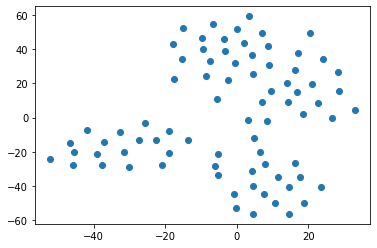

In [0]:
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1])
plt.show()

We can roughly see that there are 3 - 4 clusters. How many should we really be expecting? 

In [0]:
df_AC["Long-form"].value_counts()

acromioclavicular              40
before meals                   17
adriamycin cyclophosphamide    17
acetate                         2
antecubital                     1
abdominal circumference         1
Name: Long-form, dtype: int64

So - technically 6, but 3 of them have very few samples. 

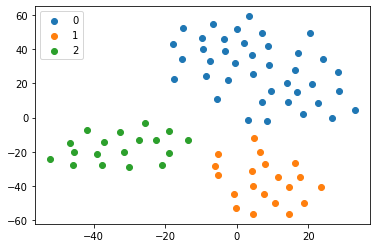

In [0]:
n_clusters=3

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(tsne_embedding)
clusters = [np.nonzero(kmeans.labels_ == i)[0] for i in range(n_clusters)]

for i in range(n_clusters):
    indices = clusters[i]
    plt.scatter(tsne_embedding[indices, 0], tsne_embedding[indices, 1], label=str(i))
plt.legend()
plt.show()


In [0]:
for i in range(3):
  print("Cluster {0}".format(i))
  for index in clusters[i]:
    print(df_AC["Long-form"][index])

Cluster 0
abdominal circumference
antecubital
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
Cluster 1
acetate
acetate
before meals
before meals
before meals
before meals
before meals
before meals
before meals
before meals
before meals
before meals
before meals
before meals
before meals
before meals
before meals
before meals
before meals
acromioclavicular
Clust

In [0]:
clusters

[array([ 2, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
        54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77]),
 array([ 0,  1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 53]),
 array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        60])]

# Creating our own dataset

Let's use acronyms for now. The idea here would be to 

Next, we want to create a dataset consisting of our own abbreviated dataset using acronyms. We first preprocess all the files following the above.
 

In [0]:
import os
import io

frames=[]

for filename in os.listdir(loc+"data/30_abbreviations/"):
  # print(filename)
  s = "{0}".format(filename)[:-4]+"|"
  with open(loc+"data/30_abbreviations/{0}".format(filename), 'r', encoding = "ISO-8859-1") as f:
      lines = f.readlines()

      # print(lines)
      fo = io.StringIO()
      stripped_lines = []
      for line in lines:
        if line[0]=='"':
          line = line[1:]
        if line[-1]=='"':
          line = line[:-1]
      
        line = s+line
        stripped_lines.append(line)
      fo.writelines(line for line in stripped_lines)
      fo.seek(0)      
      temp_df = pd.read_csv(fo, names = ["Abbreviation", "Long-form", "Text"], sep='|')
  frames.append(temp_df)
  
  df = pd.concat(frames)  #df now contains all abbreviations / long-forms / texts from annotated MIMIC-III

In [32]:
x = df[['Abbreviation', 'Long-form']].drop_duplicates().groupby(by = ['Abbreviation']).count()
x['Long-form'].mean()

3.3333333333333335

In [0]:
df[df.Abbreviation == 'AC'].head()

,Abbreviation,Long-form,Text
0,AC,acetate,5. Singulair 10 mg inhaler q. day. 6. Kadian 6...
1,AC,acetate,3. Lotrel _%#MMDD#%_ p.o. daily. 4. Atenolol 5...
2,AC,acetate,1. Bactroban applied to face 3 times a day. 2....
3,AC,acetate,5. Nitro spray prn. 6. Plavix 75 mg PO daily 7...
4,AC,abdominal circumference,The patient's prenatal care was done at Southd...


In [0]:
df.describe()

,Abbreviation,Long-form,Text
count,14386,14386,14386
unique,30,100,14114
top,FISH,over the counter,"Screening tests, such as first trimester scree..."
freq,500,469,50


Not clear to me what's a good way of generating abbreviations for single words, if we're using acronyms. 

Let's try with random strings first, perhaps.. 

In [0]:
# mapping abbreviation to random string 
import random
import string


random_str = []
for i in range(100):
  n = random.choice([2,3]) #we generate random strings of lengths 2,3. 
  random_str.append(''.join(random.choices(string.ascii_uppercase, k=n)))

print(random_str)

['EOJ', 'KQA', 'YJ', 'YH', 'GKM', 'WXK', 'BU', 'NPP', 'EUL', 'RQ', 'XVD', 'WMX', 'VGO', 'JCN', 'HTR', 'BD', 'NZ', 'MHZ', 'MQH', 'AFT', 'GZH', 'VNG', 'VNZ', 'RA', 'KXG', 'XN', 'EID', 'FH', 'UVM', 'GXG', 'SK', 'ONP', 'EP', 'JVM', 'KIP', 'DK', 'XHK', 'HLF', 'IP', 'NY', 'RY', 'SJB', 'ENV', 'TQB', 'EJ', 'WF', 'AB', 'XDZ', 'PL', 'VSH', 'NP', 'DK', 'JAL', 'SBV', 'AH', 'KTE', 'RU', 'EFV', 'SO', 'BX', 'BN', 'RM', 'CO', 'BB', 'ZST', 'EKM', 'CC', 'WY', 'OA', 'JB', 'RR', 'AO', 'VJX', 'IR', 'FL', 'NOS', 'GRB', 'MQW', 'YA', 'ZDA', 'QGK', 'PCF', 'DKJ', 'YTC', 'HKY', 'JG', 'JPJ', 'VIN', 'ANS', 'RW', 'VZ', 'FO', 'MM', 'NE', 'NC', 'SN', 'NP', 'DV', 'VTD', 'RM']


In [0]:
#define a map from long forms to random string
d = {}
count = 0
for i in set(df["Long-form"]):
  d[i] = random_str[count]
  count+=1
df["Random-Abbreviation"] = df["Long-form"].apply(lambda x: d[x])

In [0]:
df

,Abbreviation,Long-form,Text,Random-Abbreviation
0,IM,intramuscular,20. Fosamax 70 mg p.o. every Sunday. 21. Calca...,GKM
1,IM,intramuscular,The patient's hyperglycemia is well controlled...,GKM
2,IM,intramuscular,"Antibiotics were changed, he was put on clinda...",GKM
3,IM,intramuscular,PAST MEDICAL HISTORY: MEDICINES: 1. Diovan/hyd...,GKM
4,IM,intramuscular,The patient denies any intentional weight loss...,GKM
...,...,...,...,...
330,AC,acromioclavicular,Active Motion: Only flexes to 20 degrees and 3...,EJ
331,AC,acromioclavicular,No crepitation with range of motion on the kne...,EJ
332,AC,acromioclavicular,9. History of hyperlipidemia. 10. History of a...,EJ
333,AC,acromioclavicular,HISTORY OF PRESENT ILLNESS: The patient is a 5...,EJ


In [0]:
df['random-annotated-text'] = df.apply(lambda x: x['Text'].replace("<HERE>", x['Random-Abbreviation']), axis=1 )

In [0]:
df

,Abbreviation,Long-form,Text,Random-Abbreviation,random-annotated-text
0,IM,intramuscular,20. Fosamax 70 mg p.o. every Sunday. 21. Calca...,GKM,20. Fosamax 70 mg p.o. every Sunday. 21. Calca...
1,IM,intramuscular,The patient's hyperglycemia is well controlled...,GKM,The patient's hyperglycemia is well controlled...
2,IM,intramuscular,"Antibiotics were changed, he was put on clinda...",GKM,"Antibiotics were changed, he was put on clinda..."
3,IM,intramuscular,PAST MEDICAL HISTORY: MEDICINES: 1. Diovan/hyd...,GKM,PAST MEDICAL HISTORY: MEDICINES: 1. Diovan/hyd...
4,IM,intramuscular,The patient denies any intentional weight loss...,GKM,The patient denies any intentional weight loss...
...,...,...,...,...,...
330,AC,acromioclavicular,Active Motion: Only flexes to 20 degrees and 3...,EJ,Active Motion: Only flexes to 20 degrees and 3...
331,AC,acromioclavicular,No crepitation with range of motion on the kne...,EJ,No crepitation with range of motion on the kne...
332,AC,acromioclavicular,9. History of hyperlipidemia. 10. History of a...,EJ,9. History of hyperlipidemia. 10. History of a...
333,AC,acromioclavicular,HISTORY OF PRESENT ILLNESS: The patient is a 5...,EJ,HISTORY OF PRESENT ILLNESS: The patient is a 5...


OK - now to generate BERT embeddings. Note that we can't do exactly the same as above, since we aren't taking the embedding of \<HERE\> but for the respective abbreviations. To do this, we will look for the token corresponding to the abbreviation in the tokenized form. We then search for the index (assuming this token is unique, we can probably check this but I haven't done this in the current implementation yet. 

In [0]:
def obtain_BERT_embeddings_new(txt, abbrev):
  #given a text with a unique abbrev, returns the BERT embeding of abbrev. 
  tokenized_text = tokenizer.encode(txt, add_special_tokens=True)
  tokenized_abbrev = tokenizer.encode(abbrev, add_special_tokens=True)
  #below finds the index corresponding to our abbreviation
  index = [x for x in range(len(tokenized_text)) if tokenized_text[x:x+len(tokenized_abbrev)-2] == tokenized_abbrev[1:-1]][0] 
  input_id = torch.tensor([tokenizer.encode(txt, add_special_tokens=True)])
  ##need to account for possibility if len(input_id)>512. BERT only takes in max token length 512. 
  mode = 0
  if input_id.shape[1]>512:
    temp = input_id[0][0:512-len(tokenized_abbrev)+2].unsqueeze(0)
    temp2 = input_id[0][index:index+len(tokenized_abbrev)-2].unsqueeze(0)
    input_id = torch.cat([temp, temp2], dim=1) # we take the first 500 ish tokens for the sentence, and just append the abbreviation at the end. We will recover the embedding of the end abbreviation. 
    mode = 1
  try:
    if mode == 1:
      embedding = model(input_id)[0][0][512-len(tokenized_abbrev)+2:512].detach().numpy()      
    else:
      embedding = model(input_id)[0][0][index:index+len(tokenized_abbrev)-2].detach().numpy() #we recover the BERT embedding for the abbreviation.
  except IndexError:
    print(txt)
    print(tokenized_text)
    print(tokenized_abbrev)
    print(index)

  return np.mean(embedding, axis=0)

We apply this to our data. **WARNING** - this takes some time to train!

In fact - first time I ran this I got an index error. To troubleshoot this, let me run this on each abbreviation instead..

Update 1: I think the error is coming from BERT having a limit of 512 token length. 

We can either a) omit the very long sentences
b) truncate them

I like truncation more, 

In [0]:
# df["Abbreviation-embedding"] = df.apply(lambda x: obtain_BERT_embeddings_new(x["random-annotated-text"], x["Random-Abbreviation"]), axis=1)

In [0]:
df_dict = {}
for i in set(df["Abbreviation"]):
  df_dict[i] = df[df["Abbreviation"]==i]

In [0]:
df_dict["AC"]["Abbreviation-embedding"] = df_dict["AC"].apply(lambda x: obtain_BERT_embeddings_new(x["random-annotated-text"], x["Random-Abbreviation"]), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


To check that we didn't make any mistakes, let's visualize BERT embeddings for a given abbreviation. In light of the previous example, we expect to get clusters resembling different long-forms. 

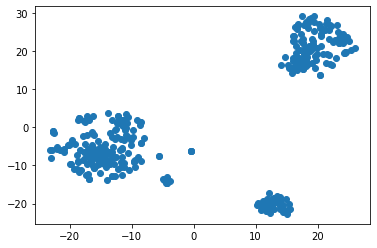

In [0]:
embedding_matrix = np.array([i for i in df_dict["AC"]["Abbreviation-embedding"]])
tsne_embedding = TSNE(n_components=2, random_state=0).fit_transform(embedding_matrix)
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1])
plt.show()

# for reasons that I don't understand, this looks different than the plot we had previously. Perhaps it's the abbreviation doing work too. 

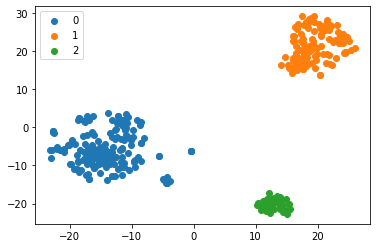

Cluster 0
acetate
acetate
acetate
acetate
abdominal circumference
abdominal circumference
assist control
assist control
assist control
assist control
assist control
assist control
assist control
assist control
assist control
antecubital
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
acromioclavicular
Cluster 1
adriamycin cyclophosphamide
adriamycin cyclophosphamide
adriamycin cyclophosphamide
adriamycin cyclophosphamide
adriamycin cyclophosphamide
a

In [0]:
n_clusters=3

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(tsne_embedding)
clusters = [np.nonzero(kmeans.labels_ == i)[0] for i in range(n_clusters)]

for i in range(n_clusters):
    indices = clusters[i]
    plt.scatter(tsne_embedding[indices, 0], tsne_embedding[indices, 1], label=str(i))
plt.legend()
plt.show()

for i in range(3):
  print("Cluster {0}".format(i))
  for index in clusters[i][:50]:
    print(df_dict["AC"]["Long-form"][index])


In [0]:
#Main training loop for random abbreviations
# for d in df_dict:
#   print(df_dict[d]["Abbreviation"][0])
#   df_dict[d]["Abbreviation-embedding"] = df_dict[d].apply(lambda x: obtain_BERT_embeddings_new(x["random-annotated-text"], x["Random-Abbreviation"]), axis=1)

OK it finally finished training (took roughly 90 minutes - could be off by a lot though)! 

Let's save it first just in case! 

In [0]:
import pickle
filename = 'df_dict.pkl'
outfile = open(filename, 'wb')
pickle.dump(df_dict, outfile)
outfile.close()

Since we saved everything into a dict, we can either work with the dict or put them back together. I want to put them back together - let me try and do that now. 

In [0]:
df.describe()

,Abbreviation,Long-form,Text,Random-Abbreviation,random-annotated-text
count,14386,14386,14386,14386,14386
unique,30,100,14114,97,14114
top,FISH,over the counter,"Screening tests, such as first trimester scree...",ONP,"Screening tests, such as first trimester scree..."
freq,500,469,50,469,50


Note that not all texts are unique! 

In [0]:
df[df["Text"]=='Screening tests, such as first trimester screen, provide risk assessments for specific conditions, but cannot definitively diagnose or exclude these conditions. Diagnostic tests, such as <HERE> and amniocentesis can definitively diagnose or exclude the presence of certain chromosome conditions, but are associated with a small risk of miscarriage."']

,Abbreviation,Long-form,Text,Random-Abbreviation,random-annotated-text
28,CVS,chorionic villus sampling,"Screening tests, such as first trimester scree...",MQH,"Screening tests, such as first trimester scree..."
32,CVS,chorionic villus sampling,"Screening tests, such as first trimester scree...",MQH,"Screening tests, such as first trimester scree..."
40,CVS,chorionic villus sampling,"Screening tests, such as first trimester scree...",MQH,"Screening tests, such as first trimester scree..."
41,CVS,chorionic villus sampling,"Screening tests, such as first trimester scree...",MQH,"Screening tests, such as first trimester scree..."
51,CVS,chorionic villus sampling,"Screening tests, such as first trimester scree...",MQH,"Screening tests, such as first trimester scree..."
54,CVS,chorionic villus sampling,"Screening tests, such as first trimester scree...",MQH,"Screening tests, such as first trimester scree..."
61,CVS,chorionic villus sampling,"Screening tests, such as first trimester scree...",MQH,"Screening tests, such as first trimester scree..."
68,CVS,chorionic villus sampling,"Screening tests, such as first trimester scree...",MQH,"Screening tests, such as first trimester scree..."
71,CVS,chorionic villus sampling,"Screening tests, such as first trimester scree...",MQH,"Screening tests, such as first trimester scree..."
81,CVS,chorionic villus sampling,"Screening tests, such as first trimester scree...",MQH,"Screening tests, such as first trimester scree..."


Reading the df_dict pickle file in case i want to reun stuff with df_dict...

In [0]:
with open(loc + '/df_dict.pkl', 'rb') as f:
  df_dict = pickle.load(f)

In [40]:
df_dict['AB']

,Abbreviation,Long-form,Text,Random-Abbreviation,random-annotated-text,Abbreviation-embedding
0,AB,ankle-brachial,7. Laryngospasm. CONSULTANTS: 1. Nephrology. 2...,XT,7. Laryngospasm. CONSULTANTS: 1. Nephrology. 2...,"[0.09551845, 0.10774581, 0.3100346, 0.23159596..."
1,AB,arterial blood,"Electrolytes were normal. Creatinine 0.4, INR ...",BG,"Electrolytes were normal. Creatinine 0.4, INR ...","[0.11425174, -0.7369192, 0.2012226, 0.05260154..."
2,AB,abortion,_%#NAME#%_ _%#NAME#%_ is a 29-year-old gravida...,BEN,_%#NAME#%_ _%#NAME#%_ is a 29-year-old gravida...,"[-0.09022899, 0.5538033, -0.16884485, 0.411863..."
3,AB,abortion,She is now bleeding quite heavily. Ultrasound ...,BEN,She is now bleeding quite heavily. Ultrasound ...,"[-0.5106026, -0.23645893, -0.07429789, 0.35843..."
4,AB,abortion,ALLERGIES: Heparin and Imitrex. PAST OB HISTOR...,BEN,ALLERGIES: Heparin and Imitrex. PAST OB HISTOR...,"[-0.179587, 0.274692, 0.04405501, 0.11255875, ..."
...,...,...,...,...,...,...
490,AB,blood group in ABO system,PROBLEM #2: Cough. The patient presented with ...,LC,PROBLEM #2: Cough. The patient presented with ...,"[0.08092612, -0.405163, -0.32352194, -0.355647..."
491,AB,blood group in ABO system,Blood cultures remained negative throughout he...,LC,Blood cultures remained negative throughout he...,"[0.1349774, -0.3998674, 0.057560258, -0.226060..."
492,AB,blood group in ABO system,Will change Albuterol with atrovent Nebs to q ...,LC,Will change Albuterol with atrovent Nebs to q ...,"[0.34831482, -0.2636292, -0.28093684, -0.19866..."
493,AB,blood group in ABO system,LABORATORY DATA: Hemoglobin 13.4. Hematocrit 3...,LC,LABORATORY DATA: Hemoglobin 13.4. Hematocrit 3...,"[0.43390676, -0.33068457, -0.026177272, -0.248..."


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Getting aggregated embedding for each random-abbreviation.

In [0]:
random_abbrev = {}

for d in df_dict:
  embedding = torch.zeros
  set(df_dict['AC']["Random-Abbreviation"])

In [0]:
agg_embeddings={}
for d in df_dict:
  random_abbrev = set(df_dict[d]["Random-Abbreviation"])
  for abbrev in random_abbrev:
    tempdf = df_dict[d][df_dict[d]["Random-Abbreviation"] == abbrev]
    agg_embeddings[abbrev] = tempdf["Abbreviation-embedding"].mean()

apparently len(agg_embeddings) = 99. It seems like when I was generating random_str, I managed to duplicate an entry!!!! 

I'll ignore this for now and work with what we have, although at some point I'll retrain everything. 

In [0]:
agg_embeddings["TUS"].shape

(768,)

# Clinical Embeddings

Next step we need to get clinical embeddings. We'll get them from https://github.com/clinicalml/embeddings. 

In [0]:
! git clone https://github.com/clinicalml/embeddings
! git pull

Cloning into 'embeddings'...
remote: Enumerating objects: 92, done.
remote: Total 92 (delta 0), reused 0 (delta 0), pack-reused 92
Unpacking objects: 100% (92/92), done.
fatal: not a git repository (or any of the parent directories): .git


In [0]:
%cd embeddings

/content/embeddings


In [0]:
import gzip
f = gzip.open('claims_cuis_hs_300.txt.gz', 'rb')
lines = f.readlines()
arr = []
for line in lines:
  arr.append(str(line))

# print(file_content[0:1000])
f.close()

In [0]:
arr[:10]

["b'14852 300\\n'",
 "b'C0028066 -0.006840 0.071309 0.109787 -0.125884 0.028182 0.077588 0.136462 -0.081349 -0.051918 0.140650 -0.132657 -0.059581 0.027221 -0.031575 0.188972 0.160837 -0.086321 -0.042469 0.032027 -0.036638 -0.096533 0.066371 -0.057614 -0.090826 -0.064901 0.233306 -0.086090 -0.090532 0.136585 0.059112 0.037142 -0.101290 -0.138499 -0.018211 -0.194694 0.053761 -0.028217 0.018264 0.059321 0.198902 0.042938 -0.097149 -0.028089 -0.009674 -0.013357 0.191163 -0.050109 0.007697 -0.027369 0.042776 0.059253 0.230374 0.046260 0.111091 0.110405 0.165698 0.166850 0.082959 -0.035322 -0.087811 0.083134 -0.022809 0.140161 0.181006 -0.019686 0.074216 0.188264 0.007731 0.127758 0.006909 0.111574 -0.141856 0.118155 0.120593 -0.131984 -0.260755 0.226798 0.125322 -0.249436 -0.196751 -0.100430 0.063402 -0.017288 -0.127527 0.003197 -0.157717 0.041447 -0.276653 0.081493 -0.057248 -0.161434 0.087417 0.106735 0.018322 -0.098366 0.062590 0.076675 0.121378 0.064758 -0.012551 0.074883 -0.205834 0.1

In [0]:
clinical_embeddings = {}
for i in arr[1:]:
  clinical_embeddings[i[2:10]] = np.array([float(i) for i in arr[1][11:-4].split(' ')])

In [0]:
print('We have a total of {} CUI embeddings'.format(len(clinical_embeddings)))

We have a total of 14852 CUI embeddings


Clinical_embeddings is our dictionary which maps a CUI code to its 300-length vector. Let's check that it's working! 

In [0]:
len(clinical_embeddings['C0020740'])

300

Transforming the CUI codes into words. Doing it using the UMLS summary dictionary below:

In [0]:
clinical_embeddings_word = {}
cuis_not_found = []
for cui, embedding in clinical_embeddings.items():
  if cui not in umls_terms_map:
    cuis_not_found.append(cui)
  else:
    word = umls_terms_map[ cui ][0][1]
  clinical_embeddings_word[ word ] = embedding

NameError: ignored

In [0]:
print('CUIs not found in UMLS map:', len(cuis_not_found))
print('CUIs with embeddings found in UMLS map:', len(clinical_embeddings_word.keys()))


# UMLS Dictionary





In [0]:
import pickle
umls_terms = pickle.load(open(loc + '/data/umls_summary.pk', 'rb'))

In [45]:
print('Unique UMLS CUIs available: ', len(umls_terms))

Unique UMLS CUIs available:  605345


Converting the UMLS CUIs into a map

In [0]:
umls_terms_map = {} # cui is the key
umls_terms_name_map = {} # name is the key
for entry in umls_terms:
  if entry[0] in umls_terms_map:
    umls_terms_map[ entry[0] ].append( entry )
  else:
    umls_terms_map[ entry[0] ] = [ entry ]
  
  if entry[1] in umls_terms_name_map:
    umls_terms_name_map[ entry[1] ].append( entry )
  else:
    umls_terms_name_map[ entry[1] ] = [ entry ]

In [0]:
len(umls_terms_name_map.keys())

In [0]:
len((umls_terms_map.keys()))

Print first 5 items of the UMLS_terms map

In [47]:
for entry in  list(islice(umls_terms_map.items(), 5)):
  print(entry[0], ' : ', entry[1][0])

C0000039  :  ['C0000039', '1,2-dipalmitoylphosphatidylcholine', 1, ['Organic Chemical', 'Pharmacologic Substance'], ['1,2-dipalmitoylphosphatidylcholine', '1,2 dipalmitoylphosphatidylcholine', '1,2-dihexadecyl-sn-glycerophosphocholine', '1,2 dihexadecyl sn glycerophosphocholine', '1,2-dipalmitoyl-glycerophosphocholine', '1,2 dipalmitoyl glycerophosphocholine', 'dipalmitoylphosphatidylcholine', 'dipalmitoylglycerophosphocholine', 'dipalmitoyllecithin', '3,5,9-trioxa-4-phosphapentacosan-1-aminium, 4-hydroxy-n,n,n-trimethyl-10-oxo-7-((1-oxohexadecyl)oxy)-, inner salt, 4-oxide', 'dipalmitoylphosphatidylcholine (substance)', 'dipalmitoyl phosphatidylcholine', 'phosphatidylcholine, dipalmitoyl', 'dppc', 'dipalmitoylphosphatidylcholine 0102', '1,2-dipalmitoylphosphatidylcholine [chemical/ingredient]']]
C0000052  :  ['C0000052', '1,4-alpha-glucan branching enzyme', 2, ['Amino Acid, Peptide, or Protein', 'Enzyme'], ['1,4-alpha-glucan branching enzyme', '1,4 alpha glucan branching enzyme', '1,4-

In [48]:
for entry in  list(islice(umls_terms_name_map.items(), 5)):
  print(entry[0], ' : ', entry[1])

1,2-dipalmitoylphosphatidylcholine  :  [['C0000039', '1,2-dipalmitoylphosphatidylcholine', 1, ['Organic Chemical', 'Pharmacologic Substance'], ['1,2-dipalmitoylphosphatidylcholine', '1,2 dipalmitoylphosphatidylcholine', '1,2-dihexadecyl-sn-glycerophosphocholine', '1,2 dihexadecyl sn glycerophosphocholine', '1,2-dipalmitoyl-glycerophosphocholine', '1,2 dipalmitoyl glycerophosphocholine', 'dipalmitoylphosphatidylcholine', 'dipalmitoylglycerophosphocholine', 'dipalmitoyllecithin', '3,5,9-trioxa-4-phosphapentacosan-1-aminium, 4-hydroxy-n,n,n-trimethyl-10-oxo-7-((1-oxohexadecyl)oxy)-, inner salt, 4-oxide', 'dipalmitoylphosphatidylcholine (substance)', 'dipalmitoyl phosphatidylcholine', 'phosphatidylcholine, dipalmitoyl', 'dppc', 'dipalmitoylphosphatidylcholine 0102', '1,2-dipalmitoylphosphatidylcholine [chemical/ingredient]']]]
1,4-alpha-glucan branching enzyme  :  [['C0000052', '1,4-alpha-glucan branching enzyme', 2, ['Amino Acid, Peptide, or Protein', 'Enzyme'], ['1,4-alpha-glucan branchi

Trying to see if we can find abbreviations in UMLS data, but we dont, we do find the long forms though and have mutiple entries for longforms 

In [49]:
semantic_types = []
for t in umls_terms:
  # semantic_types = semantic_types + t[3]
  if 'AB' in t[4] or 'AB' in t[1] or \
    'abortion' in t[4]:
    for i, entry in enumerate(t):
      print('{}: {}'.format(i, entry))
    print()

0: C0156543
1: unspecified abortion
2: 73949
3: ['Finding']
4: ['unspecified abortion', 'unspecified abortion nos', 'abortion', 'abortions', 'abortion, nos', 'abortion nos', 'preg with abortive outcome', 'pregnancy with abortive outcome', 'pregnancy with abortive outcome nos', 'pregnancy+abortive outcome nos', 'pregnancy loss', '8-04 abortions', 'abortion (disorder)', 'abortion nos (disorder)', 'unspecified abortion nos (disorder)', 'unspecified abortion (disorder)', 'abortion finding', 'pregnancy with abortive outcome (disorder)', 'pregnancy with abortive outcome nos (disorder)', 'abortion (diagnosis)', 'miscarriage or abortion', 'pregnancy resulting in fetal death', 'pregnancy with abortive outcome (o00-o08)']

0: C0392535
1: induced abortion (procedure)
2: 230829
3: ['Therapeutic or Preventive Procedure']
4: ['induced abortion (procedure)', 'abortion', 'abortions', 'abortion, induced', 'abortions, induced', 'induced abortion', 'induced abortions', 'abortion (induced)', 'abortion ind

# CUItoVec Embeddings

This website will let you interact with embeddings for over 108,000 medical concepts - http://cui2vec.dbmi.hms.harvard.edu/. Embeddings for UMLS CUIs. These embeddings were created using insurance claims for 60 million americans, 1.7 million full-text PubMed articles, and clinical notes from 20 million patients at Stanford. More information about the methods used to create these embeddings can be found in our preprint: https://arxiv.org/abs/1804.01486

In [41]:
cuitovec_embeddings = pd.read_csv(loc + '/data/cui2vec_pretrained.csv/cui2vec_pretrained.csv')
columns = cuitovec_embeddings.columns.tolist()
columns[0] = 'cui'
cuitovec_embeddings.columns = columns
cuitovec_embeddings.head()

,cui,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,...,V461,V462,V463,V464,V465,V466,V467,V468,V469,V470,V471,V472,V473,V474,V475,V476,V477,V478,V479,V480,V481,V482,V483,V484,V485,V486,V487,V488,V489,V490,V491,V492,V493,V494,V495,V496,V497,V498,V499,V500
0,C0000052,-0.004071,0.002169,-4.466913e-17,-0.006110,-0.001187,0.000047,0.007681,-0.002564,0.012169,8.510987e-17,-0.014761,0.006384,-0.010547,-0.000475,0.113440,0.058907,-0.172463,3.577867e-17,0.030226,0.011987,-0.011368,-0.000577,0.005605,-0.023046,0.004918,-0.017281,0.006766,-0.006453,-0.012901,0.003172,-0.005771,0.000374,0.007419,2.083674e-15,-0.011704,3.789422e-16,-0.004064,-0.004843,-0.009228,...,-0.039812,-0.000721,0.012088,-0.020244,-0.045197,0.022028,-0.017377,-0.010164,0.027401,-0.027074,-0.009841,-0.008304,-0.022221,0.008014,0.042113,-0.006376,0.003216,-0.000478,-0.021727,-0.006052,-0.044035,-0.011598,-0.000728,-0.002857,-0.001882,-0.062140,-0.032667,0.005931,0.025993,0.002573,-0.000316,-0.049984,-0.022582,-0.041039,0.003112,0.025915,-0.065661,0.004741,-0.004502,-0.029053
1,C0000163,-0.008389,0.002486,-3.816392e-17,-0.004083,-0.002875,0.001207,0.005683,0.002054,0.007849,4.466913e-17,-0.018256,-0.007073,-0.017077,-0.001199,0.167938,0.077537,-0.222152,2.829768e-17,0.035000,0.008202,-0.008183,-0.001576,0.003287,-0.021275,-0.000146,-0.026754,0.009185,-0.010848,-0.008649,0.003046,-0.004676,-0.007618,0.017479,4.497271e-15,0.004688,-3.653761e-16,0.001293,-0.007506,-0.014668,...,-0.122614,0.016933,-0.006705,-0.084431,-0.005476,0.094546,0.002108,-0.056572,-0.031406,-0.027577,-0.063415,-0.046911,0.062202,-0.014227,0.043626,0.018565,0.000407,0.071640,-0.081636,0.048380,0.016249,0.080315,0.001227,0.028104,0.126432,-0.069477,0.093670,-0.016682,-0.053828,-0.068102,0.053730,0.048069,-0.058616,-0.013041,-0.005875,-0.000951,-0.007084,0.057521,-0.008791,0.001159
2,C0000167,-0.008328,0.002697,-5.811324e-17,-0.014372,0.004227,0.008176,0.007521,-0.000114,0.012576,5.160802e-17,-0.019601,-0.001929,-0.025697,-0.002323,0.177741,0.085582,-0.251257,2.417771e-17,0.043778,0.010922,-0.017578,-0.002443,-0.002377,-0.027647,0.008433,-0.028108,0.005885,0.001927,-0.015647,0.004871,0.001732,-0.011444,0.028010,7.679621e-15,0.011256,-2.365729e-16,-0.001808,-0.006596,-0.003177,...,-0.150694,0.024891,-0.020137,-0.095877,-0.016489,0.091999,0.041918,-0.074253,-0.066715,0.016389,-0.100696,-0.077692,0.056323,-0.035627,0.083308,0.005769,-0.023710,0.130884,-0.090631,0.067453,0.047582,0.133206,-0.015505,0.040409,0.103901,-0.078273,0.140156,-0.048069,-0.064677,-0.110767,0.031376,0.026515,-0.064476,0.040333,-0.005710,-0.027542,0.003274,0.062406,0.020109,-0.014616
3,C0000172,-0.008589,0.002666,-1.734723e-17,-0.001215,-0.001841,-0.001273,0.002268,-0.000551,0.003284,-1.734723e-17,-0.008908,-0.003391,-0.009277,-0.000646,0.120424,0.058047,-0.149642,-6.548581e-17,0.022889,0.007105,-0.004408,-0.000724,0.004559,-0.016453,0.000134,-0.018702,0.003592,-0.008955,-0.001113,0.002061,0.000749,-0.004816,0.007368,1.804112e-15,0.005697,-5.438358e-16,0.002582,-0.006393,-0.011715,...,-0.058852,0.010184,0.004655,-0.044615,-0.003556,0.041779,0.026221,-0.028523,-0.008309,0.005916,-0.010589,-0.017557,0.032013,-0.006488,0.017609,0.012915,0.011166,0.039392,-0.015757,0.015986,0.043137,0.068181,0.002613,0.019744,0.082578,-0.066852,0.079201,-0.010654,-0.001823,-0.061107,0.007605,0.009991,-0.035895,-0.014936,0.003336,0.001816,-0.007257,0.014691,0.001276,0.001881
4,C0000215,-0.001324,-0.000040,-1.561251e-17,-0.002030,-0.000095,0.000728,0.003543,-0.001463,0.003100,4.856887e-17,-0.007702,0.001152,-0.004783,-0.000706,0.080975,0.039056,-0.120896,5.339696e-17,0.023469,0.007597,-0.009392,0.002006,0.000396,-0.017496,0.000704,-0.018367,0.007816,-0.006682,-0.011598,0.003356,-0.001783,-0.003255,0.007630,1.920230e-15,-0.004014,-2.001437e-16,0.000709,-0.004693,-0.012240,...,0.013234,-0.007240,-0.004495,0.011855,-0.002918,-0.023302,0.006409,-0.014872,-0.0552

There are 109053 CUIs with embeddings and each vector is of size 500

In [0]:
cuitovec_embeddings.shape

(109053, 501)

In [0]:
print(len(df_dict.keys()), " | ", df_dict.keys())
df_dict['AB'].head()

30  |  dict_keys(['MR', 'CVS', 'LE', 'BAL', 'CEA', 'OTC', 'FISH', 'PE', 'AB', 'AV', 'IT', 'IVF', 'RA', 'PDA', 'DC', 'PCP', 'DM', 'SBP', 'C&S', 'CTA', 'RT', 'ER', 'CA', 'OP', 'IR', 'SMA', 'DIP', 'BK', 'AC', 'IM'])


,Abbreviation,Long-form,Text,Random-Abbreviation,random-annotated-text,Abbreviation-embedding
0,AB,ankle-brachial,7. Laryngospasm. CONSULTANTS: 1. Nephrology. 2...,XT,7. Laryngospasm. CONSULTANTS: 1. Nephrology. 2...,"[0.09551845, 0.10774581, 0.3100346, 0.23159596..."
1,AB,arterial blood,"Electrolytes were normal. Creatinine 0.4, INR ...",BG,"Electrolytes were normal. Creatinine 0.4, INR ...","[0.11425174, -0.7369192, 0.2012226, 0.05260154..."
2,AB,abortion,_%#NAME#%_ _%#NAME#%_ is a 29-year-old gravida...,BEN,_%#NAME#%_ _%#NAME#%_ is a 29-year-old gravida...,"[-0.09022899, 0.5538033, -0.16884485, 0.411863..."
3,AB,abortion,She is now bleeding quite heavily. Ultrasound ...,BEN,She is now bleeding quite heavily. Ultrasound ...,"[-0.5106026, -0.23645893, -0.07429789, 0.35843..."
4,AB,abortion,ALLERGIES: Heparin and Imitrex. PAST OB HISTOR...,BEN,ALLERGIES: Heparin and Imitrex. PAST OB HISTOR...,"[-0.179587, 0.274692, 0.04405501, 0.11255875, ..."


In [0]:
# !!! Have to see a better similarity measure to find the closest CUI for a particular longform
def jaccard(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return len(intersection)/len(union)

def get_cui_for_longform( row ):
  longform = row['Long-form']
  word_sim = 0
  cui = None
  used_jaccard = False
  for key, entry in umls_terms_name_map.items():
    longform_words = longform.strip().split(' ')
    if longform in key or longform in entry[0][4]:
      cui = umls_terms_name_map.get(key, None)[0][0]
      break
    elif max([ jaccard( e.split(' '), longform_words) for e in entry[0][4] ]) > 0.60:
      cui = umls_terms_name_map.get(key, None)[0][0]
      used_jaccard = True
  row['cui'], row['used_jaccard'] = cui, used_jaccard
  return row

Checking to see how many of the long forms in the Li et al. dataset have associated CUIs from the CUItoVec embeddings. For this, first i try to extract CUIs for the long forms mentioned, then check if the resultant CUIs have embeddings in CUItoVec embeddings

In [0]:
abbr_lf_pairs = df[['Abbreviation', 'Long-form']].drop_duplicates()
abbr_lf_pairs = abbr_lf_pairs.apply(get_cui_for_longform, axis = 1)

In [0]:
abbr_lf_pairs.to_csv(loc+'/data/abbr_lf_pairs.csv')

In [0]:
# Read cached abbr_lf_pairs for faster processing
abbr_lf_pairs = pd.read_csv(loc+'/data/abbr_lf_pairs.csv')

In [62]:
abbr_lf_pairs[abbr_lf_pairs.cui.notnull()].sort_values(by=['cui'])
# abbr_lf_pairs[abbr_lf_pairs.cui.notnull()][abbr_lf_pairs.Abbreviation == 'PDA']

,Unnamed: 0,Abbreviation,Long-form,cui,used_jaccard
87,2,AB,abortion,C0000786,False
92,0,AC,acetate,C0000975,False
99,177,AC,acromioclavicular,C0001208,False
82,439,OP,operative,C0001510,False
36,116,AV,aortic valve,C0003501,False
...,...,...,...,...,...
68,409,PE,pressure equalization,C1531678,False
29,0,C&S,culture and sensitivity,C1531732,True
41,0,CTA,computed tomographic angiography,C1536105,False
24,0,RT,respiratory therapist,C1709924,False


In [52]:
print('Unique (abbr, longform) pairs: ', len(abbr_lf_pairs))
print('Long forms without a CUI: \n', len(abbr_lf_pairs[abbr_lf_pairs.cui.isna()]), '\n', abbr_lf_pairs[abbr_lf_pairs.cui.isna()])

Unique (abbr, longform) pairs:  100
Long forms without a CUI: 
 18 
     Unnamed: 0 Abbreviation  ...  cui used_jaccard
2            0          SMA  ...  NaN        False
12         157           BK  ...  NaN        False
27         152           RT  ...  NaN        False
30          47          C&S  ...  NaN        False
31          63          C&S  ...  NaN        False
34         495           DM  ...  NaN        False
42         100          CTA  ...  NaN        False
44          93          PCP  ...  NaN        False
46         498          PCP  ...  NaN        False
72         397           IR  ...  NaN        False
79           2           OP  ...  NaN        False
83           0         FISH  ...  NaN        False
85           0           AB  ...  NaN        False
88         347           AB  ...  NaN        False
89         348           AB  ...  NaN        False
90         349           AB  ...  NaN        False
91         350           AB  ...  NaN        False
95          1

In [63]:
abbr_lf_pairs_notnull = abbr_lf_pairs[abbr_lf_pairs.cui.notnull()]
print('Count of long forms with CUIs: ', len(abbr_lf_pairs_notnull))
abbr_lf_pairs_notnull.head(5)

Count of long forms with CUIs:  82


,Unnamed: 0,Abbreviation,Long-form,cui,used_jaccard
0,0,IM,intramuscular,C0021492,False
1,461,IM,intramedullary,C0021885,False
3,84,SMA,smooth muscle antibody,C0201511,False
4,87,SMA,superior mesenteric artery,C0038828,True
5,440,SMA,spinal muscular atrophy,C0026847,True


In [64]:
jaccard_lf_cuis = abbr_lf_pairs_notnull[abbr_lf_pairs_notnull.used_jaccard == True][['Long-form', 'cui']].values
for [lf, cui] in jaccard_lf_cuis:
  print('Longform: {}, CUI: {}, CUI_Info: {}'.format(lf, cui, umls_terms_map[cui]))

Longform: superior mesenteric artery, CUI: C0038828, CUI_Info: [['C0038828', 'superior mesenteric artery syndrome', 20283, ['Disease or Syndrome'], ['superior mesenteric artery syndrome', 'syndrome; superior mesenteric artery', 'chronic intermittent arteriomesenteric occlusion of the duodenum syndrome', 'mesenteric duodenal compression syndrome', 'duodenal compression syndrome, mesenteric', 'mesenteric; vascular insufficiency syndrome', 'mesenteric vascular insufficiency syndrome', 'syndrome; mesenteric vascular insufficiency', 'cast syndrome', 'syndrome, cast', 'arteriomesenteric duodenal ileus', 'duodenum, occlusion by superior mesenteric artery', 'duodenum, vascular compression', 'superior mesenteric a.syndrome', 'wilkie syndrome', 'syndrome, wilkie', 'smas - sup mesent artery syndr', 'smas - superior mesenteric artery syndrome', 'superior mesenteric artery syndrome (disorder)', 'a.mesenterica superior; syndrome', 'superior mesenteric artery syndrome [disease/finding]']]]
Longform: 

In [65]:
# Number of longforms with a CUI (82 in total) from the umls_map having a corresponding word embedding in CUItoVec
print('Size before join: ', len(abbr_lf_pairs_notnull))
abbr_lf_pairs_notnull = abbr_lf_pairs_notnull.merge(cuitovec_embeddings, on='cui', how='left')
print('Size after join: ', len(abbr_lf_pairs_notnull))
print('\nAbbrs with longform CUI embeddings: \n')
print(abbr_lf_pairs_notnull.head(5))
print('\nCount of Abbrs with longform CUI embeddings: ', len(abbr_lf_pairs_notnull[abbr_lf_pairs_notnull.V1.notnull()]))

Size before join:  82
Size after join:  82

Abbrs with longform CUI embeddings: 

   Unnamed: 0 Abbreviation  ...      V499      V500
0           0           IM  ... -0.058767  0.003671
1         461           IM  ...  0.051373 -0.003846
2          84          SMA  ...       NaN       NaN
3          87          SMA  ... -0.014783  0.012046
4         440          SMA  ... -0.082317 -0.412191

[5 rows x 505 columns]

Count of Abbrs with longform CUI embeddings:  60


In [66]:
final = abbr_lf_pairs_notnull[abbr_lf_pairs_notnull.V1.notnull()]
final.head()

,Unnamed: 0,Abbreviation,Long-form,cui,used_jaccard,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,...,V461,V462,V463,V464,V465,V466,V467,V468,V469,V470,V471,V472,V473,V474,V475,V476,V477,V478,V479,V480,V481,V482,V483,V484,V485,V486,V487,V488,V489,V490,V491,V492,V493,V494,V495,V496,V497,V498,V499,V500
0,0,IM,intramuscular,C0021492,False,-0.033358,0.014457,-8.500145e-17,-0.015395,0.001704,0.003077,0.016469,-0.000769,0.017816,1.960238e-16,-0.063835,-0.003303,-0.055777,0.013008,0.593479,0.288503,-0.816634,-1.140581e-16,0.157808,0.060407,-0.068683,0.009124,0.019139,-0.082366,0.007320,-0.064909,0.040172,-0.049536,-0.042700,0.036257,-0.008399,-0.027637,0.025290,5.242443e-15,-0.004780,...,-0.177869,0.037462,-0.014298,-0.100298,0.020476,0.160509,-0.095870,-0.047905,0.069590,-0.074834,-0.112913,-0.109799,0.002347,0.065854,0.034827,0.002128,-0.085952,0.033612,-0.184847,0.015068,-0.085073,-0.015032,-0.005580,0.035857,0.114406,-0.077955,0.080341,-0.012331,-0.127918,-0.011715,0.159301,-0.004860,0.036981,-0.032881,0.132056,0.108644,-0.092978,0.010316,-0.058767,0.003671
1,461,IM,intramedullary,C0021885,False,-0.020464,0.009543,0.000000e+00,0.008158,0.031776,0.006146,-0.004596,-0.023050,0.002755,1.630640e-16,-0.043412,0.007724,-0.039615,-0.036375,0.387538,0.224176,-0.647267,1.040834e-17,0.111677,0.092494,-0.070259,-0.017816,0.032059,-0.074501,-0.011932,-0.070582,0.036020,-0.055970,-0.150284,0.006348,-0.043818,-0.044548,-0.013942,-9.193167e-15,0.007542,...,0.069522,-0.029143,0.047593,0.000614,-0.061063,0.009085,-0.051045,0.054043,-0.032904,-0.101872,0.029936,-0.005517,0.026371,0.024034,0.058818,-0.062398,0.012098,-0.038851,0.039531,0.050943,-0.092541,-0.010082,-0.020892,0.009877,0.011813,0.016127,-0.082526,-0.130604,-0.044685,0.093410,0.067802,-0.020441,0.058892,0.033635,-0.027504,-0.020000,-0.019054,0.064186,0.051373,-0.003846
3,87,SMA,superior mesenteric artery,C0038828,True,-0.027357,0.013715,-4.510281e-17,-0.005100,-0.011926,-0.005787,0.010442,0.016566,0.019563,2.255141e-17,-0.002628,0.004023,-0.039532,0.008620,0.227821,0.112924,-0.315645,-1.049508e-16,0.016860,0.001441,-0.028891,-0.014093,-0.024860,-0.021087,-0.018165,-0.031585,-0.006663,-0.002500,-0.010109,0.013037,-0.009696,-0.002903,-0.020330,-6.430186e-15,-0.037449,...,0.047613,-0.010758,-0.006301,-0.015650,-0.000767,-0.021086,0.083450,-0.041444,0.016127,0.005471,-0.014101,0.027622,0.051445,0.002011,-0.001217,-0.078868,-0.003278,0.062717,0.031774,-0.019827,0.044082,0.017096,0.000085,0.021010,0.064605,0.001276,-0.007247,0.043236,0.030830,-0.039013,-0.073166,-0.003197,-0.019309,-0.043861,0.010534,-0.024425,0.055261,-0.045799,-0.014783,0.012046
4,440,SMA,spinal muscular atrophy,C0026847,True,-3.747259,1.401802,-8.881784e-15,-1.714435,0.528870,-0.540633,0.156201,-0.443635,1.069948,9.270362e-15,-0.765054,1.226664,-0.461569,0.744632,-1.214467,1.482305,-0.469836,-6.994405e-15,-0.256931,0.661697,-1.194106,-0.096100,-0.712509,-0.361799,0.261765,1.004605,-1.444398,1.286132,-0.923332,-0.245935,-0.459844,0.380164,-0.017264,-1.722927e-14,0.939313,...,-0.791170,0.088798,0.889133,-0.182171,-1.019792,0.557698,-0.246003,0.146058,-0.622026,-0.656025,-0.090114,-0.272273,0.716213,0.003185,0.000881,-0.235775,0.071624,0.852360,-0.379914,-0.354954,-0.239882,0.197553,-0.792795,-0.103406,0.758966,-0.447893,0.014233,-0.575311,0.334200,0.554491,0.288321,-1.136294,0.465647,0.026325,0.525313,0.198468,-0.177955,-0.271438,-0.082317,-0.412191
5,496,SMA,smooth muscle actin,C1267092,True,-0.020435,0.010426,-8.039359e-17,-0.014642,-0.004402,0.007964,0.017548,0.001605,0.021101,2.099015e-16,-0.038976,0.003856,-0.021161,-0.008226,0.449902,0.224726,-0.673251,4.553649e-17,0.103085,0.042202,-0.052002,-0.018401,0.000323,-0.064735,-0.030631,-0.086164,0.030574,-0.022544,-0.056524,-0.002356,-0.021408,-0.003331,0.017295,3.817584e-15,0.013853,...,0.125648,-0.043122,0.114201,0.067462,-0.045809,-0.102367,-0.022307,0.089669,0.000981,0.145971,0.002219,

In [0]:
len(final)

In [0]:
len(df)

In [0]:
df.head()

# Training Dataset

Here, we concatenate the aggregated embeddings of our 30 abbreviations with the cuitovec embeddings of the corresponding longforms 

--> CUItoVec embeddings of long forms (CUIs):

In [67]:
print('Size of df bfore merge: ', len(df))
longform_embedding_df = df.merge(final, on= ['Abbreviation', 'Long-form'], how='left')
print('Size of df after merge: ', len(longform_embedding_df))
longform_embedding_df_notnull = longform_embedding_df[longform_embedding_df.cui.notnull()]
print('Size of df with not null cuis: ', len(longform_embedding_df_notnull))
longform_embedding_df_notnull.head()

Size of df bfore merge:  14386
Size of df after merge:  14386
Size of df with not null cuis:  8933


,Abbreviation,Long-form,Text,Unnamed: 0,cui,used_jaccard,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,...,V461,V462,V463,V464,V465,V466,V467,V468,V469,V470,V471,V472,V473,V474,V475,V476,V477,V478,V479,V480,V481,V482,V483,V484,V485,V486,V487,V488,V489,V490,V491,V492,V493,V494,V495,V496,V497,V498,V499,V500
0,IM,intramuscular,20. Fosamax 70 mg p.o. every Sunday. 21. Calca...,0.0,C0021492,False,-0.033358,0.014457,-8.500145e-17,-0.015395,0.001704,0.003077,0.016469,-0.000769,0.017816,1.960238e-16,-0.063835,-0.003303,-0.055777,0.013008,0.593479,0.288503,-0.816634,-1.140581e-16,0.157808,0.060407,-0.068683,0.009124,0.019139,-0.082366,0.00732,-0.064909,0.040172,-0.049536,-0.0427,0.036257,-0.008399,-0.027637,0.02529,5.242443e-15,...,-0.177869,0.037462,-0.014298,-0.100298,0.020476,0.160509,-0.09587,-0.047905,0.06959,-0.074834,-0.112913,-0.109799,0.002347,0.065854,0.034827,0.002128,-0.085952,0.033612,-0.184847,0.015068,-0.085073,-0.015032,-0.00558,0.035857,0.114406,-0.077955,0.080341,-0.012331,-0.127918,-0.011715,0.159301,-0.00486,0.036981,-0.032881,0.132056,0.108644,-0.092978,0.010316,-0.058767,0.003671
1,IM,intramuscular,The patient's hyperglycemia is well controlled...,0.0,C0021492,False,-0.033358,0.014457,-8.500145e-17,-0.015395,0.001704,0.003077,0.016469,-0.000769,0.017816,1.960238e-16,-0.063835,-0.003303,-0.055777,0.013008,0.593479,0.288503,-0.816634,-1.140581e-16,0.157808,0.060407,-0.068683,0.009124,0.019139,-0.082366,0.00732,-0.064909,0.040172,-0.049536,-0.0427,0.036257,-0.008399,-0.027637,0.02529,5.242443e-15,...,-0.177869,0.037462,-0.014298,-0.100298,0.020476,0.160509,-0.09587,-0.047905,0.06959,-0.074834,-0.112913,-0.109799,0.002347,0.065854,0.034827,0.002128,-0.085952,0.033612,-0.184847,0.015068,-0.085073,-0.015032,-0.00558,0.035857,0.114406,-0.077955,0.080341,-0.012331,-0.127918,-0.011715,0.159301,-0.00486,0.036981,-0.032881,0.132056,0.108644,-0.092978,0.010316,-0.058767,0.003671
2,IM,intramuscular,"Antibiotics were changed, he was put on clinda...",0.0,C0021492,False,-0.033358,0.014457,-8.500145e-17,-0.015395,0.001704,0.003077,0.016469,-0.000769,0.017816,1.960238e-16,-0.063835,-0.003303,-0.055777,0.013008,0.593479,0.288503,-0.816634,-1.140581e-16,0.157808,0.060407,-0.068683,0.009124,0.019139,-0.082366,0.00732,-0.064909,0.040172,-0.049536,-0.0427,0.036257,-0.008399,-0.027637,0.02529,5.242443e-15,...,-0.177869,0.037462,-0.014298,-0.100298,0.020476,0.160509,-0.09587,-0.047905,0.06959,-0.074834,-0.112913,-0.109799,0.002347,0.065854,0.034827,0.002128,-0.085952,0.033612,-0.184847,0.015068,-0.085073,-0.015032,-0.00558,0.035857,0.114406,-0.077955,0.080341,-0.012331,-0.127918,-0.011715,0.159301,-0.00486,0.036981,-0.032881,0.132056,0.108644,-0.092978,0.010316,-0.058767,0.003671
3,IM,intramuscular,PAST MEDICAL HISTORY: MEDICINES: 1. Diovan/hyd...,0.0,C0021492,False,-0.033358,0.014457,-8.500145e-17,-0.015395,0.001704,0.003077,0.016469,-0.000769,0.017816,1.960238e-16,-0.063835,-0.003303,-0.055777,0.013008,0.593479,0.288503,-0.816634,-1.140581e-16,0.157808,0.060407,-0.068683,0.009124,0.019139,-0.082366,0.00732,-0.064909,0.040172,-0.049536,-0.0427,0.036257,-0.008399,-0.027637,0.02529,5.242443e-15,...,-0.177869,0.037462,-0.014298,-0.100298,0.020476,0.160509,-0.09587,-0.047905,0.06959,-0.074834,-0.112913,-0.109799,0.002347,0.065854,0.034827,0.002128,-0.085952,0.033612,-0.184847,0.015068,-0.085073,-0.015032,-0.00558,0.035857,0.114406,-0.077955,0.080341,-0.012331,-0.127918,-0.011715,0.159301,-0.00486,0.036981,-0.032881,0.132056,0.108644,-0.092978,0.010316,-0.058767,0.003671
4,IM,intramuscular,The patient denies any intentional weight loss...,0.0,C0021492,False,-0.033358,0.014457,-8.500145e-17,-0.015395,0.001704,0.003077,0.016469,-0.000769,0.017816,1.960238e-16,-0.063835,-0.003303,-0.055777,0.013008,0.593479,0.288503,-0.816634,-1.140581e-16,0.157808,0.060407,-0.068683,0.009124,0.019139,-0.082366,0.00732,-0.064909,0.040172,-0.049536,-0.0427,0.036257,-0.008399,-0.0276

Checking how many abbreviations (out of a total of 30) have turned in the long form embeddings. Looks like two abbreviations have gotten lost.

In [0]:
len(longform_embedding_df_notnull[['Abbreviation']].drop_duplicates())

--> Aggregated embeddings of abbreviations (For only the 8933 observations with CUIs and CUI embeddings). For each of the 'Text' examples in the 'longform_embedding_df_notnull' dataframe generate aggregated abbreviation embeddings.

In [0]:
longform_embedding_df_notnull['Abbr_Text'] = longform_embedding_df_notnull.apply(lambda x: x['Text'].replace("<HERE>", x['Abbreviation']), axis=1 )
longform_embedding_df_notnull.head(3)

In [0]:
longform_embedding_df_notnull.head(3)['Abbr_Text'][0]

In [0]:
longform_embedding_df_notnull["Abbreviation-embedding"] = longform_embedding_df_notnull.apply(  \
    lambda x: obtain_BERT_embeddings_new(x['Abbr_Text'], x['Abbreviation']), axis=1)

In [0]:
longform_embedding_df_notnull.head()

In [0]:
longform_embedding_df_notnull.to_csv(loc+'/data/train.csv')

In [0]:
train = pd.read_csv(loc+'/data/train.csv')

In [69]:
# Positive Samples
print('Count of positive samples: ', len(train))
print('Count of uniq long forms: ', len(train[['Abbreviation', 'Long-form']].drop_duplicates()))
print('Count of uniq shrt forms: ', len(train[['Abbreviation']].drop_duplicates()))

Count of positive samples:  8933
Count of uniq long forms:  60
Count of uniq shrt forms:  28


In [71]:
x = train[['Abbreviation', 'Long-form']].drop_duplicates().groupby(by = ['Abbreviation']).count()
x['Long-form'].mean()

2.142857142857143

In [0]:
train['label'] = 1

In [0]:
train.head(2)

In [0]:
test = [float(i) for i in train['Abbreviation-embedding'].str.replace('\n', '').str[1:-1].str.split()[0]]
print(test)
print(len(test))

In [0]:
def string_to_list(string):
  return  [float(i) for i in string.replace('\n', '')[1:-1].split()]
  

train["Abbreviation-embedding"] = train["Abbreviation-embedding"].apply(string_to_list)


In [0]:
##generating the list [V1 V2 ... V500]
arr = ["V"+str(i) for i in range(1,501)]
lfembedding = {}
for lf in set(train["Long-form"]):
  lfembedding[lf]=[]
  for i in arr:
    lfembedding[lf].append(train[train["Long-form"]==lf][i].iloc[0])
print(lfembedding)

In [0]:
abbrev_embeddings = {}
for i in set(train["Abbreviation"]):
  # abbrev_embeddings[i] = train[train["Abbreviation"]==i]["Abbreviation-embedding"].mean()
  abbrev_embeddings[i] = np.mean((train[train["Abbreviation"]==i]["Abbreviation-embedding"].tolist()), axis=1)


Next we may form  our positive dataset. Let's form a third dictionary, which remembers relation[Abbrev] = [all possible long forms].

In [0]:
relation = {}
for i in set(train["Abbreviation"]):
  relation[i] = list(train[train["Abbreviation"]==i]["Long-form"].unique())
relation

In [0]:
positive_training_dataset = []
for abbrev in relation:
  abbrev_vector = abbrev_embeddings[abbrev]
  for j in relation[abbrev]:
    positive_training_dataset.append(np.concatenate([abbrev_vector,lfembedding[j]]))

In [0]:
len(positive_training_dataset)

Here we see a problem - the way we do this we only have 60 positive samples, corresponding to the fact that we only have access to 60 long forms. 

In theory for each such point, we can generate e.g. 10 negative samples. These negative samples would be 

One problem is that our input dimension is *very* high! 

Generating negative training dataset. Method:
- For each positive training dataset (abbrev, correct long-form), we will find N closest CUI embeddings and consider (abbrev, CUI embedding) to be a negative sample. 

Note that cuitovec_embeddings is 109053 rows x 501 columns. let's first make this to something more usable.

In [0]:
##want to make a vector given by concatenating columns..

arr = ["V"+str(i) for i in range(1,501)]
cuitovec_embeddings['vec'] = cuitovec_embeddings[arr].values.tolist()

In [0]:
cuiEmbeddingList = cuitovec_embeddings['vec'].tolist()

In [0]:
cuiEmbeddingList= np.array(cuiEmbeddingList)

Next we search for nearest neighbors: 

In [0]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(cuiEmbeddingList)

Why use NN for cui embedding to introduce negative samples? Assumption: CUI embeddings have precise meanings, and we would like the abbreviation to extract the exact meaning. 

In [0]:
nbrs.kneighbors(cuiEmbeddingList)